## Financial Forecasting Project

The objective is to develop a linear model that accurately predicts quarterly revenue growth for companies using a dataset of financial and economic indicators. The model will utilize 4,000 different features from 15,000 observations to make these predictions. Success will be measured by the model's Mean Squared Error (MSE) performance on a test dataset, aiming to provide reliable revenue growth forecasts for investment decision-making.

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
import optax

# Set random seed for reproducibility
np.random.seed(420)

# Load feature matrix (X) and target variable (y) from .npy files
X = np.load("C:/Users/piyus/OneDrive/Piyush_Personal/Piyush/Financial Engineering/Courses/Self projects/Fundamental Forecasts/X.npy")
y = np.load("C:/Users/piyus/OneDrive/Piyush_Personal/Piyush/Financial Engineering/Courses/Self projects/Fundamental Forecasts/y.npy")

In [4]:
#80% Train | 10% Validation | 10% Test
i = int(0.8*len(X))
j = int(0.9*len(X))
idx = np.random.permutation(len(X))
X = X[idx]
y = y[idx]
x_train = X[:i]
y_train = y[:i]
x_val = X[i:j]
y_val = y[i:j]
x_test = X[j:]
y_test = y[j:]
#print(len(x_train))
#print(len(x_val))
#print(len(x_test))
#x_train.shape[1]

Now, we set up hyperparameter tuning for a regularized machine learning model using the Adam optimizer:

The penalty function implements L2 regularization (Ridge), which helps prevent overfitting by adding a term λ/2 Σθ² to the loss function, where θ represents model parameters.

Multiple hyperparameter lists are defined for grid search:
- Learning rates (α)
- Momentum coefficients (beta)
- Adaptive learning rates (beta2)
- Regularization strengths (λ)
- Batch sizes
- Number of models for ensemble

These hyperparameters will be used to find the optimal combination that minimizes the model's error while preventing overfitting through regularization and efficient optimization using the Adam algorithm.

In [5]:
# Define the penalty function for regularization
def penalty(θ, λ, X):
    """
    Calculate the L2 regularization penalty.
    
    Args:
    θ (array): Model parameters
    λ (float): Regularization strength
    X (array): Input features (not used in this implementation, but kept for consistency)
    
    Returns:
    float: The L2 penalty term
    """
    return λ / 2 * jnp.sum(θ**2)

# Define hyperparameter lists for grid search
# Learning rates
α_list = [0.1, 0.05, 0.01, 1e-3, 1e-4, 1e-6]

# Beta values for momentum (Adam optimizer)
beta_list = [0, 0.2, 0.5, 0.9, 0.99, 0.999]

# Beta2 values for adaptive learning rate (Adam optimizer)
beta2_list = [0, 0.2, 0.5, 0.9, 0.99, 0.999]

# Regularization strengths
λ_list = [0.01, 0.1, 0.2, 0.5]

# Batch sizes for mini-batch gradient descent
batch_size_list = [10, 20, 50, 100]

# Number of models to ensemble
n_model_list = [1, 10, 20, 50]

Now we develop the implementation through the following steps:

1. Implement essential functions for model training including loss calculation (MSE), parameter updates using Adam optimizer, and model evaluation.
2. Use JAX for efficient computation with JIT compilation and vectorization (@jax.jit, @jax.vmap).
3. Include functionality for ensemble learning (stack), visualization (plot), and mini-batch training (sample).

JAX:
JAX is a powerful Python library that combines NumPy's familiar interface with advanced features for machine learning. It provides automatic differentiation (automatically computing gradients), hardware acceleration (GPU/TPU support), and compilation optimizations.

JIT (Just-In-Time Compilation):
Just-In-Time compilation is a performance optimization technique that converts Python code into optimized machine code at runtime, rather than interpreting it line by line. When we mark a function with @jax.jit, the first time that function is called, JAX compiles it into highly efficient machine code. This compilation process might take a moment initially, but subsequent calls to the function are significantly faster because they use the compiled version. 

In [30]:
# Stack function creates multiple copies of model parameters for ensemble learning
def stack(Θ):
    return jnp.array([Θ] * n_model)

# Mean Squared Error calculation
def mse(a, b):
    return ((a - b)**2).mean()

# Visualization function to plot predictions vs actual values
def plot(x, y):
    # Find range of data
    i = min(min(x), min(y))
    j = max(max(x), max(y))
    # Create perfect prediction line
    i2 = np.linspace(i, j, len(x))
    j2 = i2
    # Plot scatter of predictions and perfect prediction line
    plt.scatter(x, y)
    plt.plot(i2, j2, color="red")
    plt.xlabel('Prediction')
    plt.ylabel('y')
    plt.legend()
    plt.show()

# JIT-compiled function to evaluate model on validation set
@jax.jit
@jax.vmap
def evaluate(Θ):
    return mse(x_val @ Θ, y_val)

# Test set evaluation
def test(Θ):
    return mse(x_test @ Θ, y_test)

# Update function for model parameters using Adam optimizer
def update(Θ, opt_state, X, y, α, β, β2, λ):
    # Loss function with L2 regularization
    def L(Θ, X, y):
        predict = X @ Θ
        return mse(predict, y) + λ * Θ @ Θ

    # Calculate gradients
    grad = jax.grad(L)(Θ, X, y)
    
    # Apply Adam optimizer
    optmizer = optax.adam(α, β, β2)
    updates, opt_state = optmizer.update(grad, opt_state)
    Θ = optax.apply_updates(Θ, updates)
    return Θ, opt_state

# JIT-compile and vectorize update function
update = jax.jit(jax.vmap(update, in_axes=(0, 0, None, None, 0, 0, 0, 0)))

# Random batch sampling for mini-batch gradient descent
def sample(batch_size):
    idx = np.random.choice(len(x_train), batch_size)
    return x_train[idx], y_train[idx]

In [7]:
num_samples, num_features = X.shape
print(f"Number of samples: {num_samples}")
print(f"Number of features: {num_features}")

Number of samples: 15000
Number of features: 4000


We now implement an advanced hyperparameter tuning strategy that combines ensemble learning with the Adam optimizer. The process begins by iterating through different batch sizes and ensemble sizes, where for each combination, multiple models are trained simultaneously with randomly sampled hyperparameters. These hyperparameters include learning rates, momentum parameters, and regularization strengths.

During training, the code initializes model parameters and optimizer states, then creates an ensemble by stacking these parameters. The training process runs for 5000 iterations, using mini-batch gradient descent where each iteration processes a random batch of training data. 

The Adam optimizer updates the model parameters using the specified hyperparameters.

After training, the code selects the best performing model from the ensemble based on validation error (MSE). The parameters and hyperparameters of this best model are stored in a dictionary, including its learning rate, regularization strength, momentum parameters, batch size, and ensemble size. All these results are collected in the θ2 list for later analysis and comparison. This comprehensive approach helps identify the optimal combination of hyperparameters while benefiting from the improved robustness that ensemble learning provides.

In [38]:
θ2 = []
# Iterate through different batch sizes and ensemble sizes
for batch_size in batch_size_list:
    for n_model in n_model_list:
        # Get number of features from training data
        n_features = x_train.shape[1]
        
        # Randomly sample hyperparameters for each model in ensemble
        α_vec = np.random.choice(α_list, n_model)      # Learning rates
        β_vec = np.random.choice(beta_list, n_model)   # Momentum parameters
        β2_vec = np.random.choice(beta2_list, n_model) # Second moment estimates
        λ_vec = np.random.choice(λ_list, n_model)      # Regularization strengths

        # Initialize Adam optimizer with first set of hyperparameters
        optmizer = optax.adam(α_vec[0], β_vec[0], β2_vec[0])
        
        # Initialize model parameters with zeros
        Θ = jnp.zeros(n_features)
        opt_state = optmizer.init(Θ)

        # Create ensemble by stacking parameters and optimizer states
        Θ = stack(Θ)
        opt_state = jax.tree.map(stack, opt_state)

        # Training loop
        for iteration in range(5000):
            # Get random batch of training data
            Xi, yi = sample(batch_size)
            
            # Update model parameters using Adam
            Θ, opt_state = update(Θ, opt_state, Xi, yi, α_vec, β_vec, β2_vec, λ_vec)

        # Select best model from ensemble based on validation error
        idx_best = jnp.argmin(evaluate(Θ))
        
        # Store best model's parameters and hyperparameters
        θ_dic = {
            "α": α_vec[idx_best],
            "λ": λ_vec[idx_best],
            "β": β_vec[idx_best],
            "β2": β2_vec[idx_best],
            "batch_size": batch_size,
            "n_model": n_model,
            "MSE": evaluate(Θ)[idx_best],
            "Θ": Θ[idx_best]
        }
        θ2.append(θ_dic)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


{'α': 0.001, 'λ': 0.01, 'β': 0.9, 'β2': 0.9, 'batch_size': 100, 'n_model': 50, 'MSE': Array(0.28223032, dtype=float32), 'Θ': Array([-2.7792785e+00,  2.5674205e+00,  1.9714857e+00, ...,
       -3.7100650e-03,  9.8252215e-04, -5.1031881e-03], dtype=float32)}
[-2.7792785e+00  2.5674205e+00  1.9714857e+00 ... -3.7100650e-03
  9.8252215e-04 -5.1031881e-03]


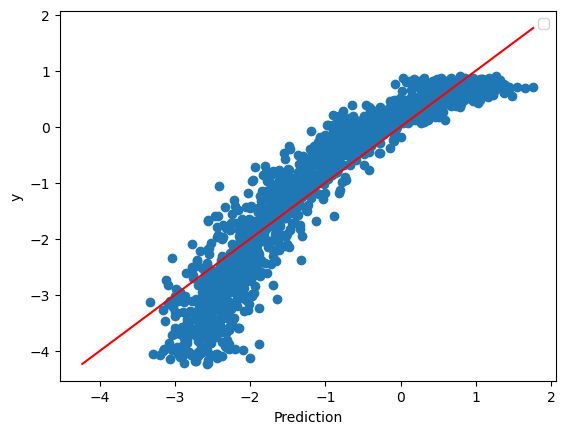

In [39]:
#Select best model
min_MSE = θ2[0]["MSE"]
min_MSE
for i in range(len(θ2)):
  if θ2[i]["MSE"] < min_MSE:
    min_MSE = θ2[i]["MSE"]
    best_model = θ2[i]
print(best_model)
print(best_model['Θ'])
pred =  x_val @ best_model['Θ']
plot(pred, y_val)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.29127756


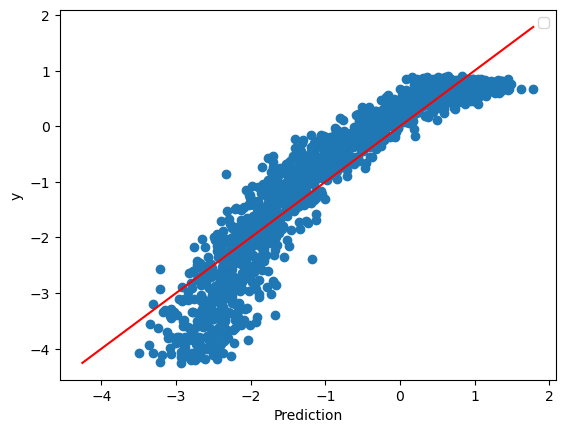

In [42]:
# Test the best model on the test set
MSE_test = test(best_model['Θ'])
print(MSE_test)  # Print the Mean Squared Error on the test set

# Generate predictions using the best model
pred = x_test @ best_model['Θ']

# Visualize the predictions vs actual values
plot(pred, y_test)

# Store the parameters of the best model
final_θ = best_model['Θ']

The Value_at_Risk function is a crucial tool in financial risk assessment that calculates the Historical Value at Risk (VaR) by comparing predicted and actual values. The function begins by calculating returns as percentage changes for both the actual and predicted values, using the formula (new value - old value)/old value. These returns represent the period-over-period changes in the financial metric being analyzed.

The function then computes the residuals, which are the differences between actual and predicted returns, to understand the model's prediction errors. Using a standard 95% confidence level (common in financial risk analysis), it calculates the historical VaR by finding the 5th percentile of these residuals. This percentile represents the threshold for the worst-case scenario that could occur with 5% probability.


In [44]:
def Value_at_Risk(x, y):
    """
    Calculate the Historical Value at Risk (VaR) based on the model predictions and actual values.
    
    Args:
    x (array): Predicted values
    y (array): Actual values
    
    Returns:
    None (prints the VaR)
    """
    # Calculate actual and predicted returns
    actual_returns = (y[1:] - y[:-1]) / y[:-1]
    predicted_returns = (x[1:] - x[:-1]) / x[:-1]
    
    # Calculate residuals (difference between actual and predicted returns)
    residuals = actual_returns - predicted_returns
    
    # Set confidence level for VaR
    confidence_level = 0.95
    percentile = 1 - confidence_level
    
    # Calculate Historical VaR
    historical_var = np.percentile(residuals, percentile * 100)
    historical_var = round(historical_var, 2)
    
    # Print the result
    print(f"Historical VaR at 95% confidence level: {historical_var}%")

# Calculate and print VaR for the best model
Value_at_Risk(pred, y_test)

Historical VaR at 95% confidence level: -4.57%


In [12]:
def f(X):
    """
    Prediction function using the final model parameters.
    
    Args:
    X (array): Input features
    
    Returns:
    array: Predicted values
    """
    return X @ final_θ